- plot shap_values for 
 - models #16 and #17
 - 5 samples and 50 samples
 - public and private data
- plot attr_all_22085_genes
 - models #16 and #17
 - use same samples as above
 - public and private data
- get_plot_per_cell_type() plots attributions coloured by cell type

In [1]:
%%capture output
!pip install shap
!pip install anndata
!pip install ipywidgets
!pip install --upgrade jupyter
!pip install IProgress

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import shap

import anndata as ad
import scipy

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
os.chdir('../..')

In [4]:
lrz_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/'
index_path = lrz_path + 'open-problems-multimodal-3rd-solution/input/preprocess/cite/'

In [5]:
# all_22001_genes: 22001 features, handselected_gene_ids: 84 handselected genes
all_22001_genes = np.loadtxt('2.preprocess_to_feature/cite/all_22001_genes_names.txt', dtype=str)
handselected_gene_ids = np.loadtxt('2.preprocess_to_feature/cite/handselected_84_gene_ids.txt', dtype=str)

In [6]:
# all 22085 genes sorted totally alphabetically
train_column = np.load(index_path + "train_cite_raw_inputs_idxcol.npz", allow_pickle=True)["columns"]
train_column

array(['ENSG00000121410_A1BG', 'ENSG00000268895_A1BG-AS1',
       'ENSG00000175899_A2M', ..., 'ENSG00000162378_ZYG11B',
       'ENSG00000159840_ZYX', 'ENSG00000074755_ZZEF1'], dtype=object)

In [7]:
# function for plotting shap values
def shap_beeswarm(shap_values, X_test):
    shap.initjs()
    shap.summary_plot(shap_values[0], X_test.to_df(), feature_names=X_test.var_names)

def shap_bar_plot(shap_values, X_test):
    shap.initjs()
    shap.summary_plot(list(shap_values), plot_type = 'bar', feature_names = X_test.var_names)
    # 140 classes = each regression output

In [8]:
# get top n features from shap plots
def get_top_features(shap_values, xtest, top_n):
    shap_sum = np.abs(shap_values).sum(axis=0)
    top_features_indices = np.argsort(shap_sum)[::-1][:top_n]  # Get the indices of the top n features
    top_feature_names_shap = xtest.var_names[top_features_indices]
    return top_feature_names_shap

In [9]:
# function for plot: plot top 10 features colouring datapoints by cell type
def get_plot_per_cell_type(shap_values, xtest, show=True, save=False, filename=None, all_attr=False):   # all_attr=True if attr_all_genes passed instead of svd shap values
    
    if all_attr:
        # in this case: have 22085 columns, not totally sorted but first 22001 columns sorted and next 84 columns sorted
        # => need total order (=train_column) to match xtest
        # TODO for now only shap_values[0], at some point consider all 140 classes
        shap_values[0] = shap_values[0].reindex(columns=train_column)

    # get top 10 features (see shap beeswarm plot)
    top_feature_names_shap = get_top_features(shap_values[0], xtest, 10)
    
    # create df with shap values of top 10 features + cell type    
    shap_cell_types = {}
    for feature in top_feature_names_shap:
        column_name = 'SHAP ' + feature.split('_')[-1]
#         column_values = shap_values[0, :, xtest.var_names.get_loc(feature)]   # use this if shap_values 3D array
        column_values = np.array(shap_values[0])[:, xtest.var_names.get_loc(feature)]   # use this if shap_values (or attr_all_22085...) dict of dataframes
        shap_cell_types[column_name] = column_values

    # Add 'Cell Type' column
    shap_cell_types['Cell Type'] = xtest.obs['cell_type']

    # Create DataFrame
    shap_cell_types = pd.DataFrame(shap_cell_types)

    
    # code for actual plot:

    # Assign different colors to each class
    colors = {'BP': 'red', 'EryP': 'blue', 'HSC': 'green', 'MasP': 'orange', 'MkP': 'purple', 'MoP': 'yellow', 'NeuP': 'pink'}

    ## legend ##
    legend_fig, legend_ax = plt.subplots(figsize=(2, 2))

    for class_label, color in colors.items():
        legend_ax.scatter([], [], color=color, label=f'Cell type {class_label}')

    legend_ax.legend(loc='center', bbox_to_anchor=(0.5, 1.2), ncol=len(colors), frameon=False)
    legend_ax.axis('off')
    ## legend ##


    # plot shap values:
    fig, ax = plt.subplots(figsize=(8, 10))

    # x_limit = (shap_values[0].min()-0.05, shap_values[0].max()+0.05)  # this is min and max for shap_values[0], TODO change once all 140 classes are considered
    x_limit = (shap_values[0].min().min()-0.05, shap_values[0].max().max()+0.05)  # above if array, this row if dict of dataframes
    
    # Remove y-axis ticks and labels
    ax.yaxis.set_visible(False)

    class_offsets = {}   # add vertical offset per class
    y = 0
    # Iterate over the columns in shap_cell_types to create subplots
    for i, column in enumerate(shap_cell_types.columns[:-1], start=1):

        ax = fig.add_subplot(len(shap_cell_types.columns)-1, 1, i)

        # Set the x-axis limits and label
        ax.set_xlim(x_limit)
        ax.set_xlabel(column)

        ax.yaxis.set_visible(False)

        # Plot the dots for the current column
        for index, row in shap_cell_types.iterrows():
            shap_value = row[column]
            class_label = row['Cell Type']
            color = colors[class_label]
            
            ##### add vertical offset per class ###
            # Check if the class_label is already in the class_offsets dictionary
            if class_label not in class_offsets:
                class_offsets[class_label] = y

            # Add the vertical offset to the y-coordinate of the dot
            y_offset = class_offsets[class_label]
            ##### add vertical offset per class ###
            
            # ax.plot(shap_value, 0, marker='o', color=color, markersize=2)  # without offset
            ax.plot(shap_value, y_offset, marker='o', color=color, markersize=2)

            # Increment the vertical offset for the next class_label
            y += 1
            
            
        
            
    fig.tight_layout(rect=[0, 0.1, 1, 1]) 
    legend_fig.subplots_adjust(top=0.1, bottom=0.05)
    
    # save plot if save=True -> need to have filename as param
    if save:
        if filename is None:
            raise ValueError("A filename must be provided when save=True.")
        plt.savefig(f'4.model/pred/plots/{filename}.png')

    if show:
        plt.show()
    else:
        plt.close()

### plots for model #16

In [10]:
# shap_values = np.load('shap_values_16_50_samples.npy', allow_pickle=True).astype(float)
# shap_values = np.load('4.model/pred/shap_values_16_restructured.npy', allow_pickle=True).astype(float)
shap_values = np.load('4.model/pred/shap_values_16_50_samples_restructured.npy', allow_pickle=True).astype(float)
xtest = ad.read_h5ad('4.model/pred/X_test_shap_16_50_samples.h5ad')
xtest

AnnData object with n_obs × n_vars = 350 × 212
    obs: 'day', 'donor', 'cell_type', 'technology'

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


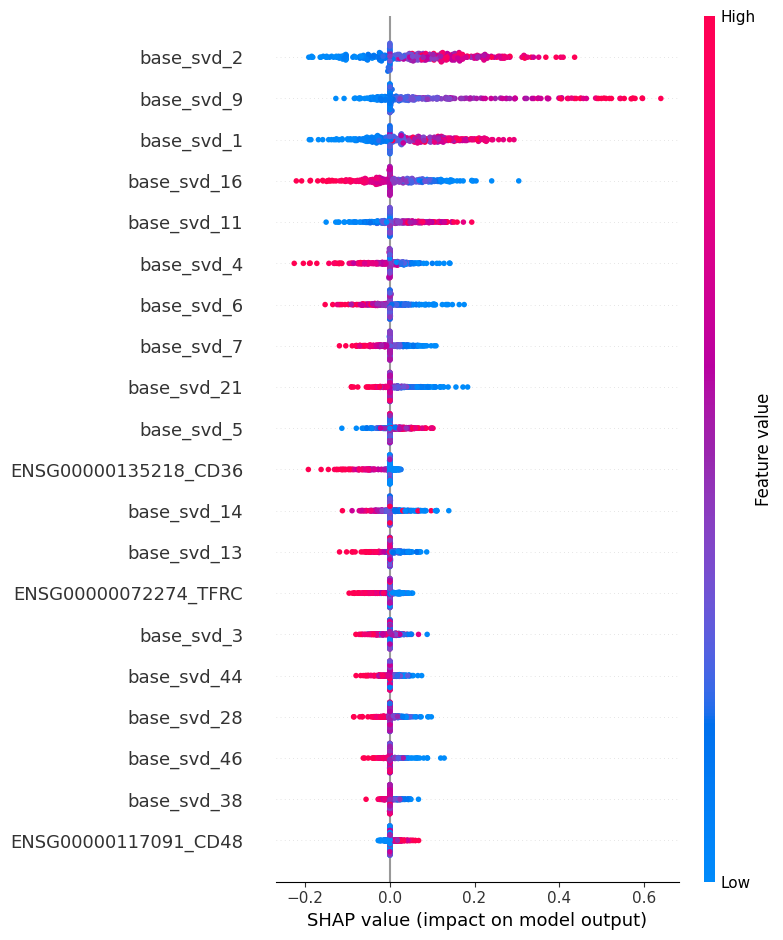

In [11]:
shap_beeswarm(shap_values, xtest)
# goal: get this plot as SHAP / features instead of SHAP / SVD components + features

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


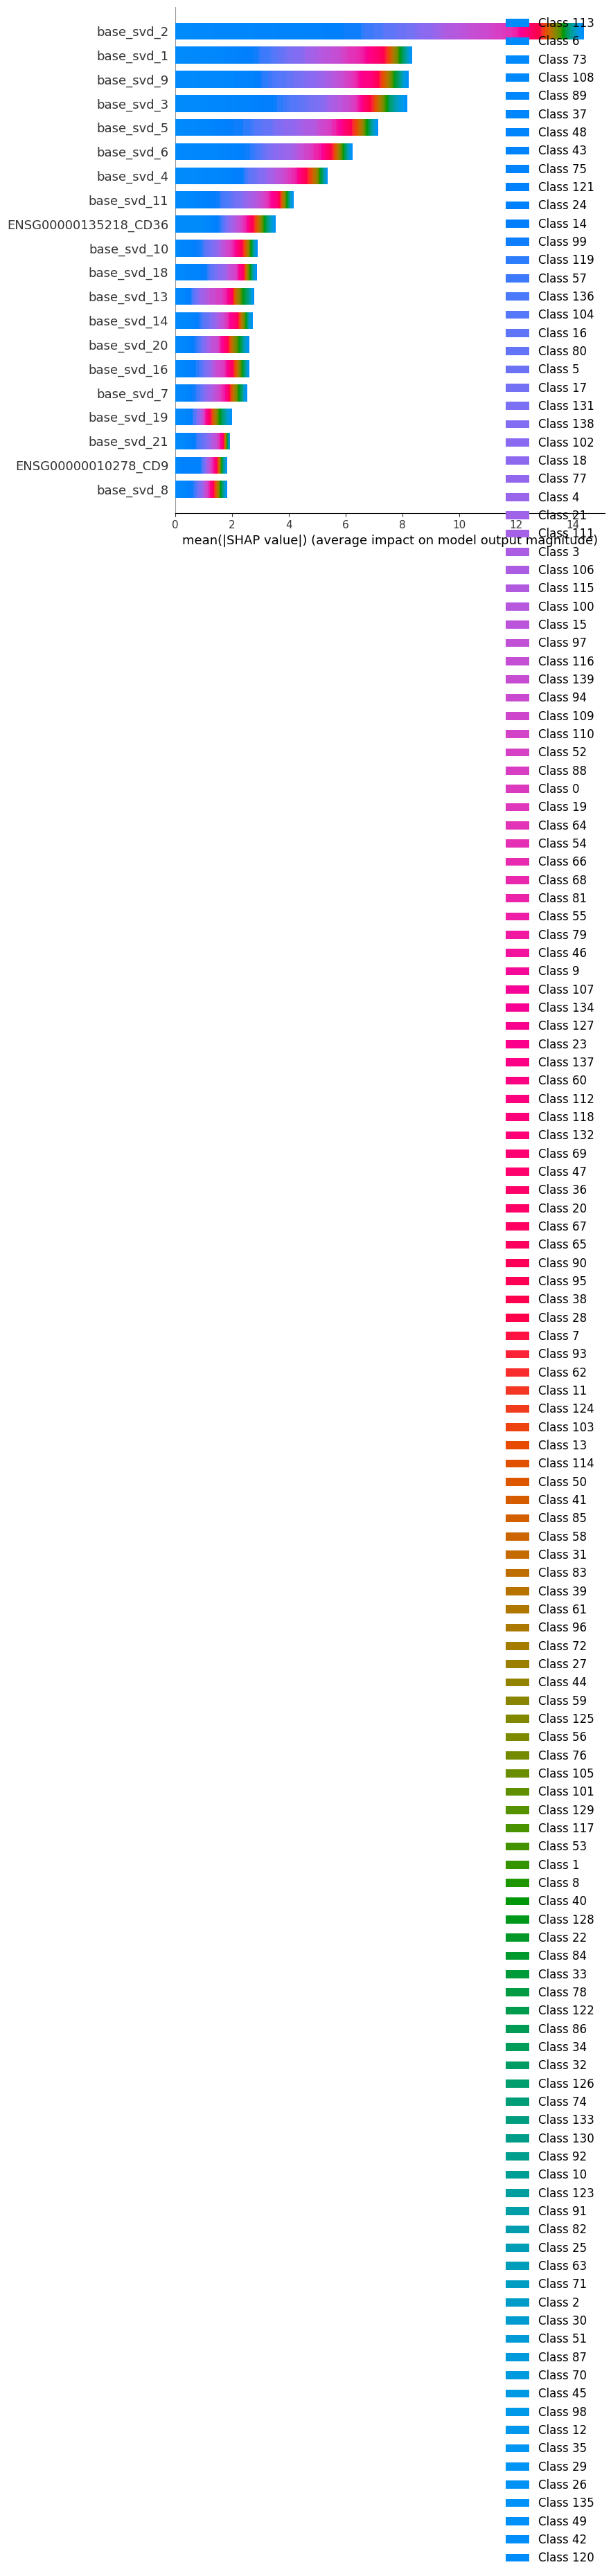

In [12]:
shap_bar_plot(shap_values, xtest)

### shap plot with backpropagated gene attributions

In [13]:
test_inputs = scipy.sparse.load_npz(index_path + "test_cite_raw_inputs_values.sparse.npz")
# test_inputs = pd.DataFrame(test_inputs.toarray(), columns=list(all_22001_genes)+list(handselected_gene_ids))   # order?????? if directly from file probably totally ordered, not 22001+84
test_inputs = pd.DataFrame(test_inputs.toarray(), columns=train_column)   # should be correct order (totally ordered)

# get cell ids
test_ids = np.load(index_path + "test_cite_raw_inputs_idxcol.npz", allow_pickle=True)
test_index = test_ids["index"]
len(test_index)

test_inputs.index = test_index

test_inputs.head(2)

ENSG00000121410_A1BG  ENSG00000268895_A1BG-AS1  \
83d6659a6a32                   0.0                       0.0   
d98594f13d2e                   0.0                       0.0   

              ENSG00000175899_A2M  ENSG00000245105_A2M-AS1  \
83d6659a6a32                  0.0                      1.0   
d98594f13d2e                  0.0                      0.0   

              ENSG00000166535_A2ML1  ENSG00000128274_A4GALT  \
83d6659a6a32                    0.0                     0.0   
d98594f13d2e                    0.0                     0.0   

              ENSG00000094914_AAAS  ENSG00000081760_AACS  \
83d6659a6a32                   3.0                   2.0   
d98594f13d2e                   1.0                   1.0   

              ENSG00000109576_AADAT  ENSG00000103591_AAGAB  ...  \
83d6659a6a32                    1.0                    0.0  ...   
d98594f13d2e                    0.0                    2.0  ...   

              ENSG00000153975_ZUP1  ENSG00000086827_ZW10  \
83d6659a6a32                   0.0                   2.0   
d98594f13d2e                   1.0                   2.0   

              ENSG00000174442_ZWILCH  ENSG00000122952_ZWINT  \
83d6659a6a32                     4.0                    7.0   
d98594f13d2e                     2.0                    3.0   

              ENSG00000198205_ZXDA  ENSG00000198455_ZXDB  \
83d6659a6a32                   0.0                   0.0   
d98594f13d2e                   0.0                   0.0   

              ENSG00000070476_ZXDC  ENSG00000162378_ZYG11B  \
83d6659a6a32                   0.0                     0.0   
d98594f13d2e                   0.0                     1.0   

              ENSG00000159840_ZYX  ENSG00000074755_ZZEF1  
83d6659a6a32                  3.0                    0.0  
d98594f13d2e                  4.0                    1.0  

[2 rows x 22085 columns]

In [14]:
# cell ids used in xtest and SHAP:
sample_cells = xtest.obs_names
sample_cells

Index(['5cb9daaca7ac', '57b5bce6a192', '11e72851054b', 'dd7e07a59b0c',
       '02a718f16011', '6394c11656fe', 'a2af6a685598', 'ac979f76ee93',
       'a61470aaf1e9', '26a307e81dfe',
       ...
       '9214757d9c46', 'f54e662e39d5', '08e9d202795f', '1ba247236795',
       'ae21155f291c', 'cc3261680720', '74cebc7a6024', '14a5dcfe9d2b',
       'e0ea983d557f', '6b5612d3264c'],
      dtype='object', name='cell_id', length=350)

In [15]:
# create xtest_all_genes: for shap plot, containing all 22085 genes instead of svd components
xtest_all_genes = test_inputs.loc[sample_cells]
print(xtest_all_genes.shape)
xtest_all_genes.head(2)

(350, 22085)


ENSG00000121410_A1BG  ENSG00000268895_A1BG-AS1  \
cell_id                                                        
5cb9daaca7ac                   0.0                       0.0   
57b5bce6a192                   0.0                       1.0   

              ENSG00000175899_A2M  ENSG00000245105_A2M-AS1  \
cell_id                                                      
5cb9daaca7ac                  0.0                      0.0   
57b5bce6a192                  0.0                      0.0   

              ENSG00000166535_A2ML1  ENSG00000128274_A4GALT  \
cell_id                                                       
5cb9daaca7ac                    0.0                     0.0   
57b5bce6a192                    0.0                     0.0   

              ENSG00000094914_AAAS  ENSG00000081760_AACS  \
cell_id                                                    
5cb9daaca7ac                   0.0                   0.0   
57b5bce6a192                   0.0                   2.0   

              ENSG00000109576_AADAT  ENSG00000103591_AAGAB  ...  \
cell_id                                                     ...   
5cb9daaca7ac                    0.0                    0.0  ...   
57b5bce6a192                    0.0                    0.0  ...   

              ENSG00000153975_ZUP1  ENSG00000086827_ZW10  \
cell_id                                                    
5cb9daaca7ac                   0.0                   0.0   
57b5bce6a192                   1.0                   0.0   

              ENSG00000174442_ZWILCH  ENSG00000122952_ZWINT  \
cell_id                                                       
5cb9daaca7ac                     0.0                    0.0   
57b5bce6a192                     2.0                    4.0   

              ENSG00000198205_ZXDA  ENSG00000198455_ZXDB  \
cell_id                                                    
5cb9daaca7ac                   0.0                   0.0   
57b5bce6a192                   0.0                   2.0   

              ENSG00000070476_ZXDC  ENSG00000162378_ZYG11B  \
cell_id                                                      
5cb9daaca7ac                   0.0                     1.0   
57b5bce6a192                   1.0                     2.0   

              ENSG00000159840_ZYX  ENSG00000074755_ZZEF1  
cell_id                                                   
5cb9daaca7ac                  1.0                    0.0  
57b5bce6a192                  2.0                    1.0  

[2 rows x 22085 columns]

In [16]:
# attr_all_22085_genes = pd.read_pickle('4.model/pred/attr_all_22085_genes_16_50_samples.pkl')
attr_all_22085_genes = pd.read_pickle(lrz_path + 'large_preprocessed_files/attr_all_genes/attr_all_22085_genes_16_50_samples.pkl')
# attr_all_22085_genes = attr_all_22085_genes.reindex(columns=train_column)  # change column order to have all columns sorted and in same order as xtest_all_genes
attr_all_22085_genes[0].head(2)

ENSG00000121410_A1BG  ENSG00000268895_A1BG-AS1  ENSG00000175899_A2M  \
0             -0.000039                 -0.000108             0.001539   
1              0.000064                  0.000346            -0.000896   

   ENSG00000245105_A2M-AS1  ENSG00000166535_A2ML1  ENSG00000128274_A4GALT  \
0                 0.000235              -0.000015               -0.001444   
1                -0.000224               0.000016                0.000908   

   ENSG00000094914_AAAS  ENSG00000081760_AACS  ENSG00000109576_AADAT  \
0              0.000596             -0.005306              -0.000497   
1             -0.001883              0.005648               0.000096   

   ENSG00000103591_AAGAB  ...  ENSG00000188404_SELL  ENSG00000124570_SERPINB6  \
0               0.000329  ...              -0.01017                 -0.002227   
1              -0.000041  ...               0.00000                  0.000000   

   ENSG00000235169_SMIM1  ENSG00000095932_SMIM24  ENSG00000137642_SORL1  \
0                    0.0                     0.0              -0.013633   
1                    0.0                     0.0               0.000000   

   ENSG00000128040_SPINK2  ENSG00000072274_TFRC  ENSG00000205542_TMSB4X  \
0                0.006514              0.020438                     0.0   
1                0.020803              0.037623                     0.0   

   ENSG00000133112_TPT1  ENSG00000026025_VIM  
0                   0.0                  0.0  
1                   0.0                  0.0  

[2 rows x 22085 columns]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


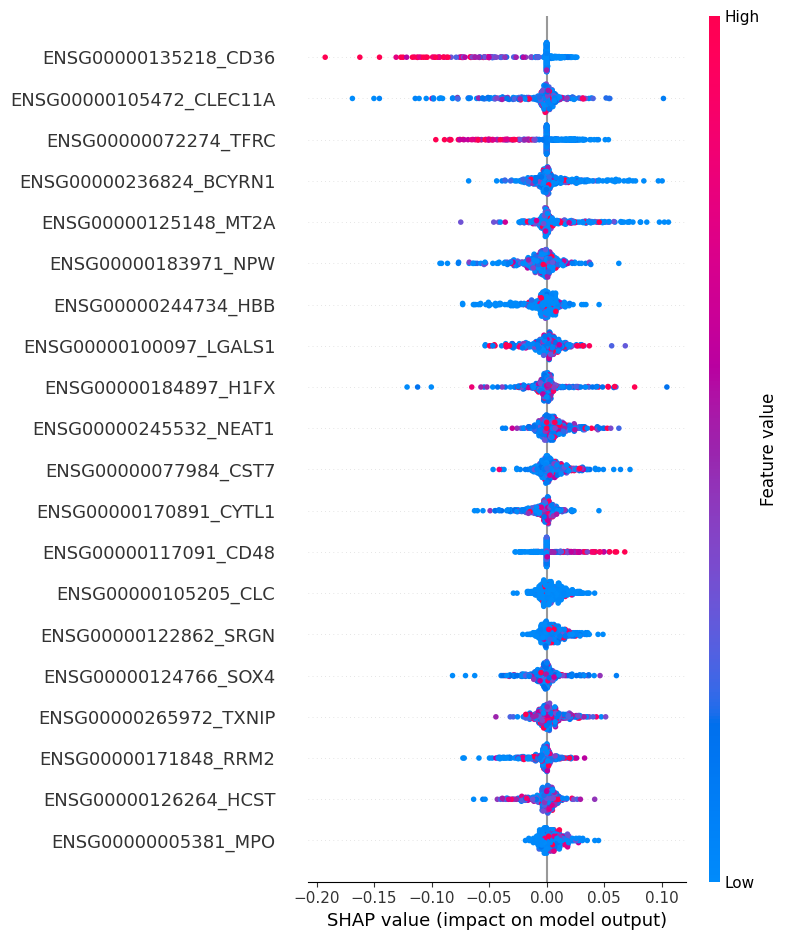

In [17]:
attr_all_22085_genes[0] = attr_all_22085_genes[0].reindex(columns=train_column)
shap.initjs()
shap.summary_plot(np.array(attr_all_22085_genes[0]), xtest_all_genes, feature_names=xtest_all_genes.columns)
# shap_beeswarm(attr_all_22085_genes, xtest_all_genes)   # TODO need to coordinate column order first before using function

In [18]:
# get top 20 features (see shap beeswarm plot)
top_20 = get_top_features(attr_all_22085_genes[0], ad.AnnData(xtest_all_genes), 20)
print(top_20)
# np.save('4.model/pred/top_feature_names_16.npy', top_20)

Index(['ENSG00000135218_CD36', 'ENSG00000105472_CLEC11A',
       'ENSG00000072274_TFRC', 'ENSG00000236824_BCYRN1',
       'ENSG00000125148_MT2A', 'ENSG00000183971_NPW', 'ENSG00000244734_HBB',
       'ENSG00000100097_LGALS1', 'ENSG00000184897_H1FX',
       'ENSG00000245532_NEAT1', 'ENSG00000077984_CST7',
       'ENSG00000170891_CYTL1', 'ENSG00000117091_CD48', 'ENSG00000105205_CLC',
       'ENSG00000122862_SRGN', 'ENSG00000124766_SOX4', 'ENSG00000265972_TXNIP',
       'ENSG00000171848_RRM2', 'ENSG00000126264_HCST', 'ENSG00000005381_MPO'],
      dtype='object')


### plot shap values per cell type similar to shap.summary_plot(shap_values[0], xtest)

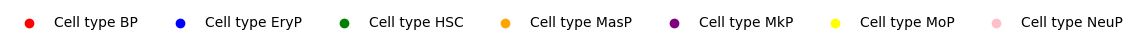

In [19]:
# get_plot_per_cell_type(shap_values, xtest, show=True, save=False, filename=None, all_attr=False)
get_plot_per_cell_type(attr_all_22085_genes, ad.AnnData(X=xtest_all_genes, obs=xtest.obs), save=True, filename='attr_16_50_samples', all_attr=True)

### plots for model #17

In [20]:
# shap_values = np.load('shap_values_16_50_samples.npy', allow_pickle=True).astype(float)
# shap_values = np.load('4.model/pred/shap_values_16_restructured.npy', allow_pickle=True).astype(float)
shap_values = np.load('4.model/pred/shap_values_17_50_samples_restructured.npy', allow_pickle=True).astype(float)
xtest = ad.read_h5ad('4.model/pred/X_test_shap_17_50_samples.h5ad')
xtest

AnnData object with n_obs × n_vars = 350 × 148
    obs: 'day', 'donor', 'cell_type', 'technology'

In [21]:
shap_beeswarm(shap_values, xtest)
# goal: get this plot as SHAP / features instead of SHAP / SVD components + features

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


### shap plot with backpropagated gene attributions

In [22]:
# attr_all_22085_genes = pd.read_pickle('4.model/pred/attr_all_22085_genes_17_50_samples.pkl')
attr_all_22085_genes = pd.read_pickle(lrz_path + 'large_preprocessed_files/attr_all_genes/attr_all_22085_genes_17_50_samples.pkl')
# attr_all_22085_genes = attr_all_22085_genes.reindex(columns=train_column)
attr_all_22085_genes[0].head(2)

ENSG00000121410_A1BG  ENSG00000268895_A1BG-AS1  ENSG00000175899_A2M  \
0              0.000224                  0.000277             0.000304   
1             -0.000021                  0.000105            -0.000008   

   ENSG00000245105_A2M-AS1  ENSG00000166535_A2ML1  ENSG00000128274_A4GALT  \
0                 0.001039               0.000021               -0.001013   
1                -0.000086              -0.000008               -0.000221   

   ENSG00000094914_AAAS  ENSG00000081760_AACS  ENSG00000109576_AADAT  \
0             -0.004067             -0.003513              -0.000175   
1              0.000356             -0.000006              -0.000150   

   ENSG00000103591_AAGAB  ...  ENSG00000188404_SELL  ENSG00000124570_SERPINB6  \
0               0.000285  ...                   0.0                  0.000000   
1              -0.000447  ...                   0.0                  0.006332   

   ENSG00000235169_SMIM1  ENSG00000095932_SMIM24  ENSG00000137642_SORL1  \
0                    0.0                0.000000               0.000000   
1                    0.0                0.002259              -0.001898   

   ENSG00000128040_SPINK2  ENSG00000072274_TFRC  ENSG00000205542_TMSB4X  \
0                     0.0                   0.0                     0.0   
1                     0.0                   0.0                     0.0   

   ENSG00000133112_TPT1  ENSG00000026025_VIM  
0                   0.0                  0.0  
1                   0.0                  0.0  

[2 rows x 22085 columns]

In [23]:
attr_all_22085_genes[0] = attr_all_22085_genes[0].reindex(columns=train_column)
shap.initjs()
shap.summary_plot(np.array(attr_all_22085_genes[0]), xtest_all_genes, feature_names=xtest_all_genes.columns)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [24]:
# get top 20 features (see shap beeswarm plot)
top_20 = get_top_features(attr_all_22085_genes, ad.AnnData(xtest_all_genes), 20)
print(top_20)
# np.save('4.model/pred/top_feature_names_17.npy', top_20)

Index(['ENSG00000135218_CD36', 'ENSG00000184897_H1FX', 'ENSG00000265972_TXNIP',
       'ENSG00000100097_LGALS1', 'ENSG00000010278_CD9', 'ENSG00000117091_CD48',
       'ENSG00000183971_NPW', 'ENSG00000245532_NEAT1',
       'ENSG00000101745_ANKRD12', 'ENSG00000105205_CLC',
       'ENSG00000196565_HBG2', 'ENSG00000124766_SOX4', 'ENSG00000072274_TFRC',
       'ENSG00000077984_CST7', 'ENSG00000122862_SRGN', 'ENSG00000136997_MYC',
       'ENSG00000123405_NFE2', 'ENSG00000125148_MT2A',
       'ENSG00000105472_CLEC11A', 'ENSG00000135655_USP15'],
      dtype='object')


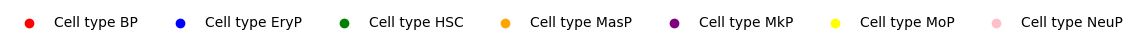

In [24]:
get_plot_per_cell_type(attr_all_22085_genes, ad.AnnData(X=xtest_all_genes, obs=xtest.obs), save=True, filename='attr_17_50_samples', all_attr=True)

## plots for private data

#### plots for model #16

In [25]:
shap_values = np.load('4.model/pred/shap_values_16_50_samples_p.npy', allow_pickle=True).astype(float)
xtest = ad.read_h5ad('4.model/pred/private_test_input_128_svd_50_samples.h5ad')
xtest

AnnData object with n_obs × n_vars = 350 × 212
    obs: 'kaggle_dataset', 'day', 'donor', 'cell_type'

In [26]:
shap_beeswarm(shap_values, xtest)
# goal: get this plot as SHAP / features instead of SHAP / SVD components + features

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


#### shap plot with backpropagated gene attributions

In [27]:
# load private test input data (before svd)
# TODO private_test_input instead?
private_test_input_raw = pd.read_pickle('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data/20220830_citeseq_rna_count_test_input_private_raw.pkl')
private_test_input_raw.head()

gene_ids                         ENSG00000121410_A1BG  \
CATAAGCAGCATGATA-1-('27678', 7)                   0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                   0.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                   0.0   
TCATGAGGTGGATTTC-1-('27678', 7)                   0.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                   1.0   

gene_ids                         ENSG00000268895_A1BG-AS1  \
CATAAGCAGCATGATA-1-('27678', 7)                       0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                       1.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                       0.0   
TCATGAGGTGGATTTC-1-('27678', 7)                       0.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                       0.0   

gene_ids                         ENSG00000175899_A2M  ENSG00000245105_A2M-AS1  \
CATAAGCAGCATGATA-1-('27678', 7)                  0.0                      0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                  0.0                      0.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                  0.0                      0.0   
TCATGAGGTGGATTTC-1-('27678', 7)                  0.0                      0.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                  0.0                      0.0   

gene_ids                         ENSG00000166535_A2ML1  \
CATAAGCAGCATGATA-1-('27678', 7)                    0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                    0.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                    0.0   
TCATGAGGTGGATTTC-1-('27678', 7)                    0.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                    0.0   

gene_ids                         ENSG00000128274_A4GALT  ENSG00000094914_AAAS  \
CATAAGCAGCATGATA-1-('27678', 7)                     0.0                   0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                     0.0                   0.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                     0.0                   0.0   
TCATGAGGTGGATTTC-1-('27678', 7)                     0.0                   1.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                     0.0                   0.0   

gene_ids                         ENSG00000081760_AACS  ENSG00000109576_AADAT  \
CATAAGCAGCATGATA-1-('27678', 7)                   0.0                    0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                   0.0                    0.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                   0.0                    0.0   
TCATGAGGTGGATTTC-1-('27678', 7)                   1.0                    0.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                   3.0                    0.0   

gene_ids                         ENSG00000103591_AAGAB  ...  \
CATAAGCAGCATGATA-1-('27678', 7)                    2.0  ...   
GGTGATTGTATGAAAC-1-('27678', 7)                    1.0  ...   
ATAGGCTAGCTCTGTA-1-('27678', 7)                    0.0  ...   
TCATGAGGTGGATTTC-1-('27678', 7)                    1.0  ...   
TAAGCGTTCGGCTGGT-1-('27678', 7)                    0.0  ...   

gene_ids                         ENSG00000153975_ZUP1  ENSG00000086827_ZW10  \
CATAAGCAGCATGATA-1-('27678', 7)                   0.0                   0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                   0.0                   0.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                   0.0                   0.0   
TCATGAGGTGGATTTC-1-('27678', 7)                   1.0                   0.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                   1.0                   0.0   

gene_ids                         ENSG00000174442_ZWILCH  \
CATAAGCAGCATGATA-1-('27678', 7)                     0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                     1.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)                     0.0   
TCATGAGGTGGATTTC-1-('27678', 7)                     0.0   
TAAGCGTTCGGCTGGT-1-('27678', 7)                     1.0   

gene_ids                         ENSG00000122952_ZWINT  ENSG00000198205_ZXDA  \
CATAAGCAGCATGATA-1-('27678', 7)                    4.0                   0.0   
GGTGATTGTATGAAAC-1-('27678', 7)                    1.0                   0.0   
ATAGGCTAGCTCTGTA-1-('27678', 7)      

In [28]:
# same cell ids used in xtest and SHAP:
sample_cells = np.array(xtest.obs_names)
sample_cells[:5]

array(["CTCCCTCGTATGAAAC-1-('32606', 7)",
       "CATGCAATCGAAATCC-1-('27678', 7)",
       "AAGCGAGGTTCATCGA-1-('31800', 7)",
       "TTCGCTGAGAAAGTCT-1-('27678', 7)",
       "TCCAGAACATCTCATT-1-('31800', 7)"], dtype=object)

In [29]:
# create xtest_all_genes: for shap plot, containing all 22085 genes instead of svd components
xtest_all_genes = private_test_input_raw.loc[sample_cells]
print(xtest_all_genes.shape)
xtest_all_genes.head()

(350, 22085)


gene_ids                         ENSG00000121410_A1BG  \
CTCCCTCGTATGAAAC-1-('32606', 7)                   0.0   
CATGCAATCGAAATCC-1-('27678', 7)                   0.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                   0.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                   0.0   
TCCAGAACATCTCATT-1-('31800', 7)                   0.0   

gene_ids                         ENSG00000268895_A1BG-AS1  \
CTCCCTCGTATGAAAC-1-('32606', 7)                       1.0   
CATGCAATCGAAATCC-1-('27678', 7)                       0.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                       0.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                       0.0   
TCCAGAACATCTCATT-1-('31800', 7)                       0.0   

gene_ids                         ENSG00000175899_A2M  ENSG00000245105_A2M-AS1  \
CTCCCTCGTATGAAAC-1-('32606', 7)                  0.0                      0.0   
CATGCAATCGAAATCC-1-('27678', 7)                  0.0                      0.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                  0.0                      0.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                  0.0                      0.0   
TCCAGAACATCTCATT-1-('31800', 7)                  0.0                      0.0   

gene_ids                         ENSG00000166535_A2ML1  \
CTCCCTCGTATGAAAC-1-('32606', 7)                    0.0   
CATGCAATCGAAATCC-1-('27678', 7)                    0.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                    0.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                    0.0   
TCCAGAACATCTCATT-1-('31800', 7)                    0.0   

gene_ids                         ENSG00000128274_A4GALT  ENSG00000094914_AAAS  \
CTCCCTCGTATGAAAC-1-('32606', 7)                     0.0                   0.0   
CATGCAATCGAAATCC-1-('27678', 7)                     0.0                   0.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                     0.0                   1.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                     0.0                   1.0   
TCCAGAACATCTCATT-1-('31800', 7)                     0.0                   0.0   

gene_ids                         ENSG00000081760_AACS  ENSG00000109576_AADAT  \
CTCCCTCGTATGAAAC-1-('32606', 7)                   1.0                    0.0   
CATGCAATCGAAATCC-1-('27678', 7)                   0.0                    0.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                   0.0                    0.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                   3.0                    0.0   
TCCAGAACATCTCATT-1-('31800', 7)                   0.0                    0.0   

gene_ids                         ENSG00000103591_AAGAB  ...  \
CTCCCTCGTATGAAAC-1-('32606', 7)                    0.0  ...   
CATGCAATCGAAATCC-1-('27678', 7)                    1.0  ...   
AAGCGAGGTTCATCGA-1-('31800', 7)                    2.0  ...   
TTCGCTGAGAAAGTCT-1-('27678', 7)                    2.0  ...   
TCCAGAACATCTCATT-1-('31800', 7)                    0.0  ...   

gene_ids                         ENSG00000153975_ZUP1  ENSG00000086827_ZW10  \
CTCCCTCGTATGAAAC-1-('32606', 7)                   0.0                   0.0   
CATGCAATCGAAATCC-1-('27678', 7)                   0.0                   1.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                   1.0                   0.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                   0.0                   0.0   
TCCAGAACATCTCATT-1-('31800', 7)                   0.0                   0.0   

gene_ids                         ENSG00000174442_ZWILCH  \
CTCCCTCGTATGAAAC-1-('32606', 7)                     0.0   
CATGCAATCGAAATCC-1-('27678', 7)                     2.0   
AAGCGAGGTTCATCGA-1-('31800', 7)                     1.0   
TTCGCTGAGAAAGTCT-1-('27678', 7)                     0.0   
TCCAGAACATCTCATT-1-('31800', 7)                     0.0   

gene_ids                         ENSG00000122952_ZWINT  ENSG00000198205_ZXDA  \
CTCCCTCGTATGAAAC-1-('32606', 7)                    0.0                   0.0   
CATGCAATCGAAATCC-1-('27678', 7)                    5.0                   0.0   
AAGCGAGGTTCATCGA-1-('31800', 7)      

In [30]:
# attr_all_22085_genes = pd.read_pickle('4.model/pred/attr_all_22085_genes_16_50_samples_p.pkl')
attr_all_22085_genes = pd.read_pickle(lrz_path + 'large_preprocessed_files/attr_all_genes/attr_all_22085_genes_16_50_samples_p.pkl')

# attr_all_22085_genes = attr_all_22085_genes.reindex(columns=train_column)
attr_all_22085_genes[0].head(2)

ENSG00000121410_A1BG  ENSG00000268895_A1BG-AS1  ENSG00000175899_A2M  \
0              0.000298                  0.000451            -0.000898   
1             -0.000017                  0.000160            -0.000390   

   ENSG00000245105_A2M-AS1  ENSG00000166535_A2ML1  ENSG00000128274_A4GALT  \
0                 0.000341               0.000032                0.001201   
1                -0.000453              -0.000005                0.000746   

   ENSG00000094914_AAAS  ENSG00000081760_AACS  ENSG00000109576_AADAT  \
0             -0.002951               0.00755               0.000339   
1              0.000328               0.00182              -0.000185   

   ENSG00000103591_AAGAB  ...  ENSG00000188404_SELL  ENSG00000124570_SERPINB6  \
0              -0.000090  ...                   0.0                    0.0000   
1               0.000238  ...                   0.0                    0.0012   

   ENSG00000235169_SMIM1  ENSG00000095932_SMIM24  ENSG00000137642_SORL1  \
0              -0.000284                     0.0                0.00000   
1               0.000000                     0.0               -0.00411   

   ENSG00000128040_SPINK2  ENSG00000072274_TFRC  ENSG00000205542_TMSB4X  \
0                0.009688                   0.0                     0.0   
1                0.012520                   0.0                     0.0   

   ENSG00000133112_TPT1  ENSG00000026025_VIM  
0             -0.010834                  0.0  
1              0.000000                  0.0  

[2 rows x 22085 columns]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


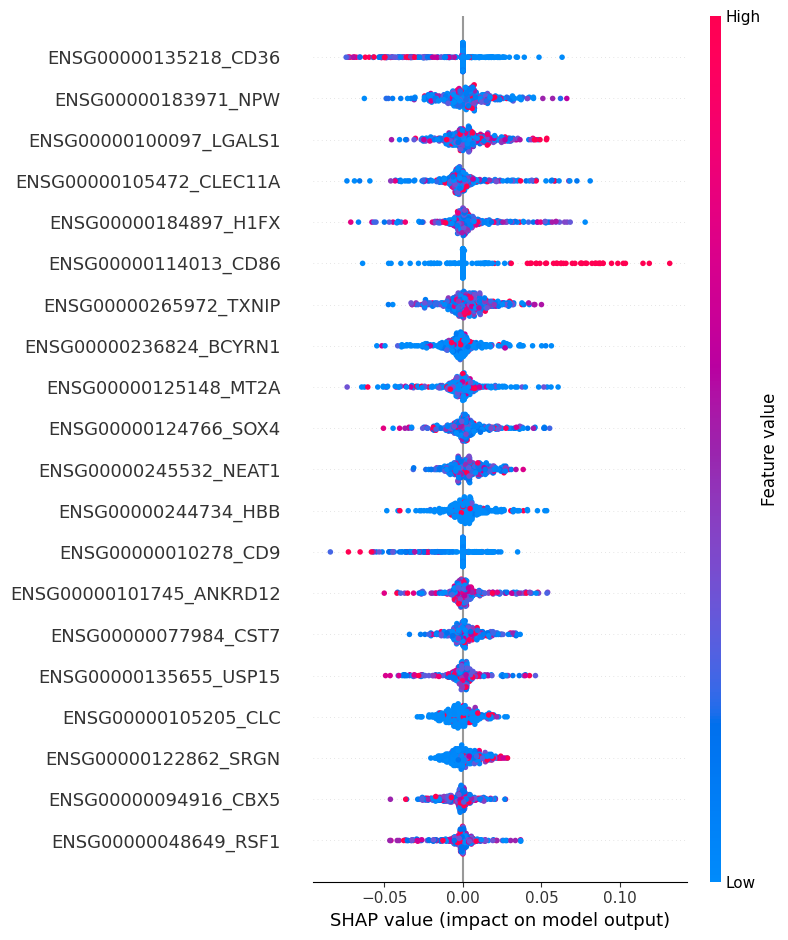

In [32]:
attr_all_22085_genes[0] = attr_all_22085_genes[0].reindex(columns=train_column)
shap.initjs()
shap.summary_plot(np.array(attr_all_22085_genes[0]), xtest_all_genes, feature_names=xtest_all_genes.columns)

In [34]:
# get top 20 features (see shap beeswarm plot)
top_20 = get_top_features(attr_all_22085_genes[0], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20)
print(top_20)
# np.save('4.model/pred/top_feature_names_16_p.npy', top_20)

Index(['ENSG00000135218_CD36', 'ENSG00000183971_NPW', 'ENSG00000100097_LGALS1',
       'ENSG00000105472_CLEC11A', 'ENSG00000184897_H1FX',
       'ENSG00000114013_CD86', 'ENSG00000265972_TXNIP',
       'ENSG00000236824_BCYRN1', 'ENSG00000125148_MT2A',
       'ENSG00000124766_SOX4', 'ENSG00000245532_NEAT1', 'ENSG00000244734_HBB',
       'ENSG00000010278_CD9', 'ENSG00000101745_ANKRD12',
       'ENSG00000077984_CST7', 'ENSG00000135655_USP15', 'ENSG00000105205_CLC',
       'ENSG00000122862_SRGN', 'ENSG00000094916_CBX5', 'ENSG00000048649_RSF1'],
      dtype='object', name='gene_ids')


X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


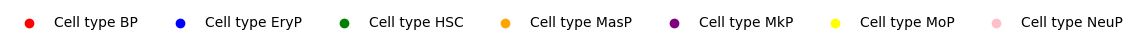

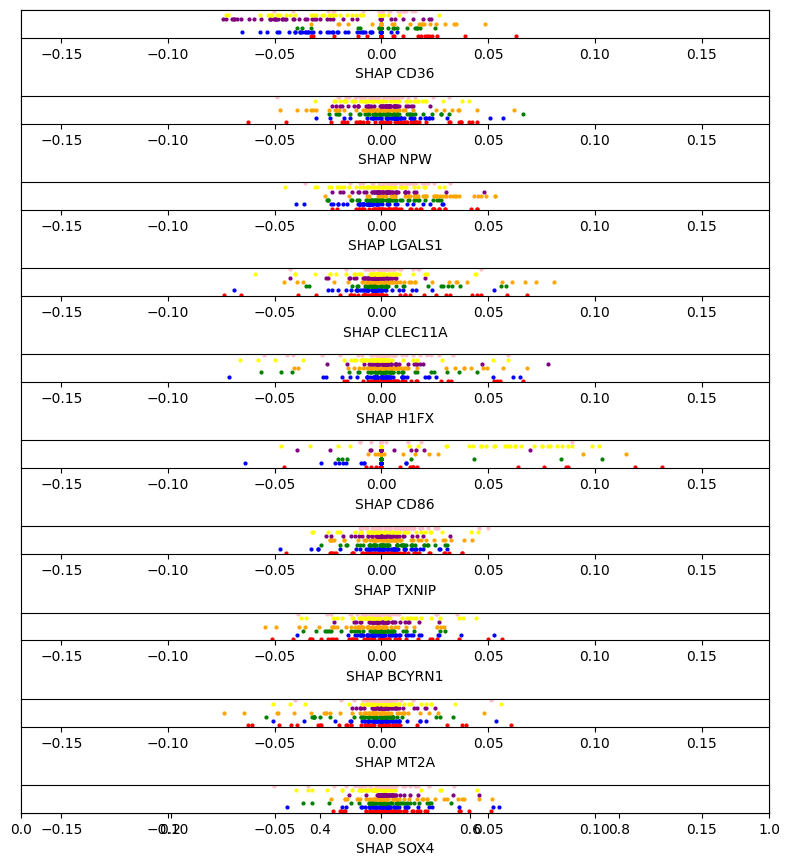

In [35]:
get_plot_per_cell_type(attr_all_22085_genes, ad.AnnData(X=xtest_all_genes, obs=xtest.obs), save=True, filename='attr_16_50_samples_p', all_attr=True)

#### plots for model #17

In [36]:
shap_values = np.load('4.model/pred/shap_values_17_50_samples_p.npy', allow_pickle=True).astype(float)
xtest = ad.read_h5ad('4.model/pred/private_test_input_64_svd_50_samples.h5ad')
xtest

AnnData object with n_obs × n_vars = 350 × 148
    obs: 'kaggle_dataset', 'day', 'donor', 'cell_type'

In [37]:
shap_beeswarm(shap_values, xtest)
# goal: get this plot as SHAP / features instead of SHAP / SVD components + features

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


#### shap plot with backpropagated gene attributions

In [38]:
# attr_all_22085_genes = pd.read_pickle('4.model/pred/attr_all_22085_genes_17_50_samples_p.pkl')
attr_all_22085_genes = pd.read_pickle(lrz_path + 'large_preprocessed_files/attr_all_genes/attr_all_22085_genes_17_50_samples_p.pkl')

# attr_all_22085_genes = attr_all_22085_genes.reindex(columns=train_column)
attr_all_22085_genes[0].head(2)

ENSG00000121410_A1BG  ENSG00000268895_A1BG-AS1  ENSG00000175899_A2M  \
0              0.000092                  0.000246             0.000361   
1             -0.000074                  0.000388            -0.000240   

   ENSG00000245105_A2M-AS1  ENSG00000166535_A2ML1  ENSG00000128274_A4GALT  \
0                 0.000903               0.000024               -0.000299   
1                 0.001097               0.000062               -0.001001   

   ENSG00000094914_AAAS  ENSG00000081760_AACS  ENSG00000109576_AADAT  \
0             -0.002838             -0.001823               0.000231   
1              0.005089              0.006846               0.001264   

   ENSG00000103591_AAGAB  ...  ENSG00000188404_SELL  ENSG00000124570_SERPINB6  \
0               0.000140  ...              0.000000                  0.007116   
1               0.000882  ...              0.001284                  0.000000   

   ENSG00000235169_SMIM1  ENSG00000095932_SMIM24  ENSG00000137642_SORL1  \
0                    0.0                0.000000               0.000000   
1                    0.0               -0.022162              -0.019837   

   ENSG00000128040_SPINK2  ENSG00000072274_TFRC  ENSG00000205542_TMSB4X  \
0                0.000979                   0.0                0.000000   
1                0.000000                   0.0               -0.010808   

   ENSG00000133112_TPT1  ENSG00000026025_VIM  
0                   0.0                  0.0  
1                   0.0                  0.0  

[2 rows x 22085 columns]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


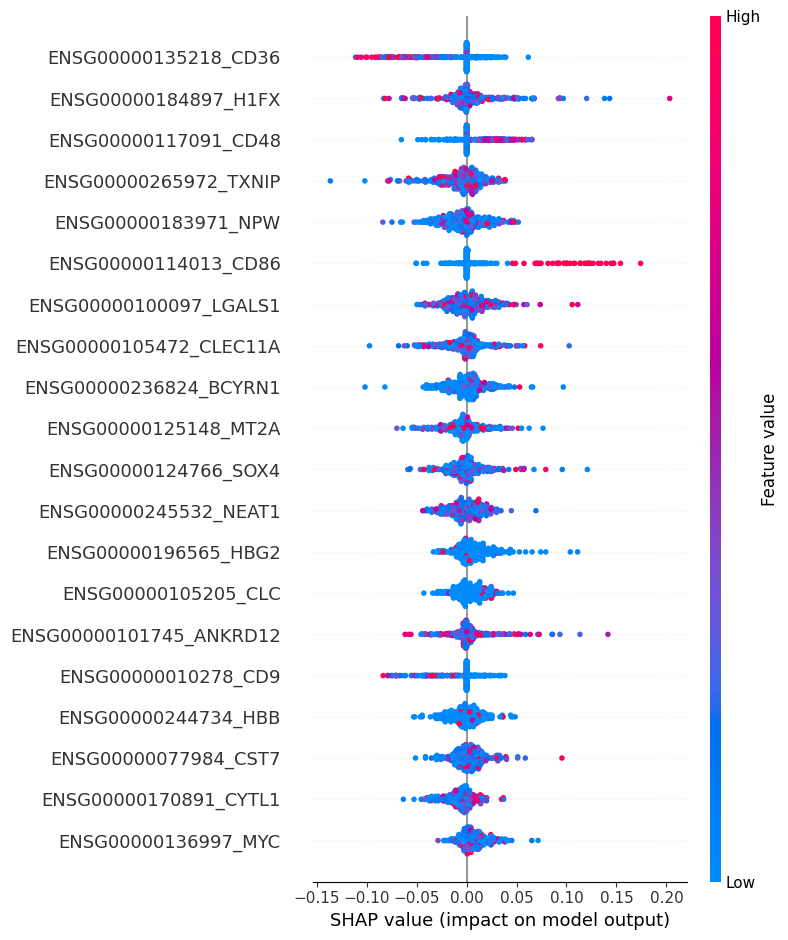

In [40]:
attr_all_22085_genes[0] = attr_all_22085_genes[0].reindex(columns=train_column)
shap.initjs()
shap.summary_plot(np.array(attr_all_22085_genes[0]), xtest_all_genes, feature_names=xtest_all_genes.columns)

In [42]:
# get top 20 features (see shap beeswarm plot)
top_20 = get_top_features(attr_all_22085_genes[0], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20) 
print(top_20)
# np.save('4.model/pred/top_feature_names_17_p.npy', top_20)

Index(['ENSG00000135218_CD36', 'ENSG00000184897_H1FX', 'ENSG00000117091_CD48',
       'ENSG00000265972_TXNIP', 'ENSG00000183971_NPW', 'ENSG00000114013_CD86',
       'ENSG00000100097_LGALS1', 'ENSG00000105472_CLEC11A',
       'ENSG00000236824_BCYRN1', 'ENSG00000125148_MT2A',
       'ENSG00000124766_SOX4', 'ENSG00000245532_NEAT1', 'ENSG00000196565_HBG2',
       'ENSG00000105205_CLC', 'ENSG00000101745_ANKRD12', 'ENSG00000010278_CD9',
       'ENSG00000244734_HBB', 'ENSG00000077984_CST7', 'ENSG00000170891_CYTL1',
       'ENSG00000136997_MYC'],
      dtype='object', name='gene_ids')


X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.


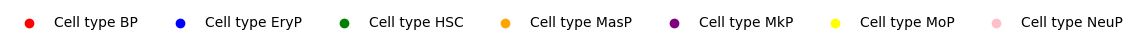

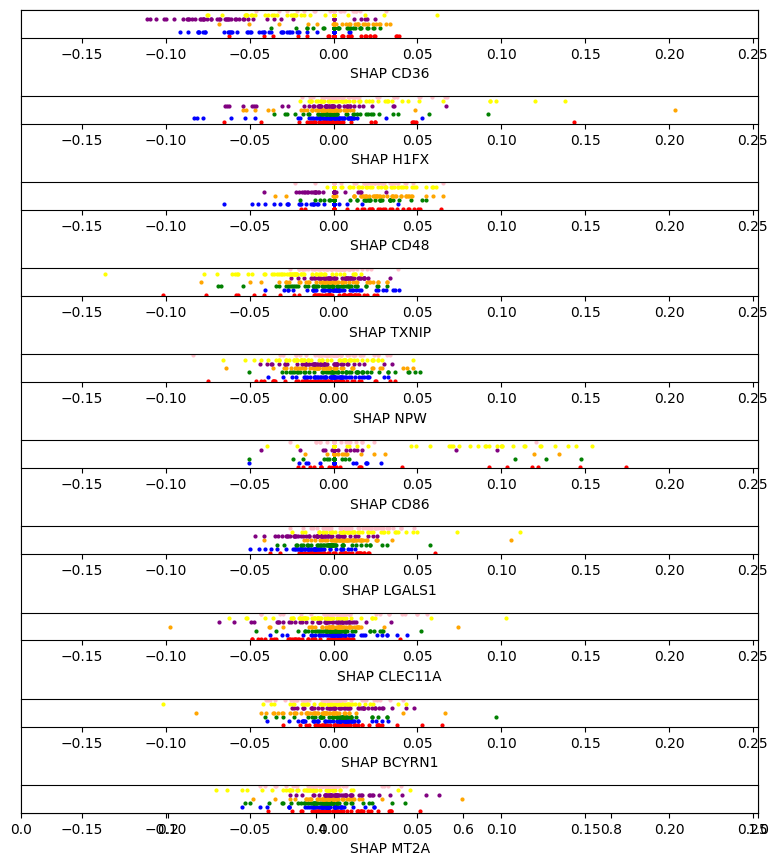

In [43]:
get_plot_per_cell_type(attr_all_22085_genes, ad.AnnData(X=xtest_all_genes, obs=xtest.obs), save=True, filename='attr_17_50_samples_p', all_attr=True)